In [1]:
#import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
#read data 
batch_data = pd.read_csv("downloads/data/batch_meta_combine.csv")

X_train_scaled = pd.read_csv("downloads/data/X_train_scaled.csv",header=None)
X_val_scaled = pd.read_csv("downloads/data/X_val_scaled.csv",header=None)
X_test_scaled = pd.read_csv("downloads/data/X_test_scaled.csv",header=None)

y_train = pd.read_csv("downloads/data/y_train.csv")
y_train = list(y_train['group_class'])

y_val = pd.read_csv("downloads/data/y_val.csv")
y_val = list(y_val['group_class'])

y_test = pd.read_csv("downloads/data/y_test.csv")
y_test = list(y_test['group_class'])

num_features = 3000

# Subset X Data to top features
X_train_scaled = X_train_scaled.iloc[:, : num_features]
X_val_scaled = X_val_scaled.iloc[:, : num_features]
X_test_scaled = X_test_scaled.iloc[:, : num_features]

In [3]:
#PCA with 95% variation
pca = PCA(.95)

pca.fit(X_train_scaled)
#PCA transformed data
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
X_val = pca.transform(X_val_scaled)

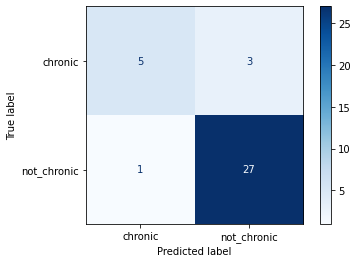

In [4]:
#logistic regression using both default solver and penalty
#fit model using training and apply on test data
logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter=5000, penalty='l2')
logisticRegr.fit(X_train, y_train)
logisticRegr.score(X_test, y_test)

#confusion matrix 
plot_confusion_matrix(logisticRegr, X_test, y_test, cmap=plt.cm.Blues)

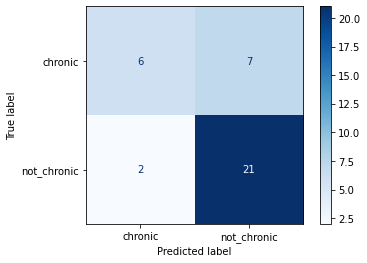

In [5]:
#optimal model based on validation data: saga and l2
logisticRegr = LogisticRegression(solver = 'saga',max_iter=5000, penalty='l2')
logisticRegr.fit(X_train, y_train)
logisticRegr.score(X_val, y_val)

#confusion matrix 
plot_confusion_matrix(logisticRegr, X_val, y_val, cmap=plt.cm.Blues)

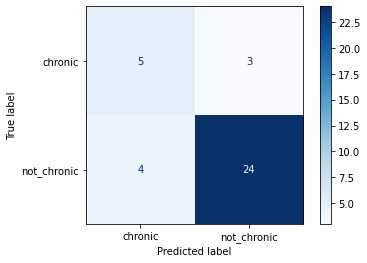

In [6]:
#logistic regression using saga and penalty l2
#fit model using training and apply on test data
logisticRegr = LogisticRegression(solver = 'saga',max_iter=5000, penalty='l2')
logisticRegr.fit(X_train, y_train)
logisticRegr.score(X_test, y_test)

#confusion matrix 
plot_confusion_matrix(logisticRegr, X_test, y_test, cmap=plt.cm.Blues)

In [ ]:
# Build RF classifier to use in feature selection

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# Build step forward feature selection; select 10 features
sfs1 = sfs(clf,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

In [ ]:
#selected features 
feat_cols = list(sfs1.k_feature_idx_)

In [ ]:
#logistic regression using only the selected features
logre = LogisticRegression(solver = 'lbfgs',max_iter=5000, penalty = 'l2')
logre.fit(X_train[:, feat_cols], y_train)

#confusion matrix
plot_confusion_matrix(logre, X_test[:, feat_cols], y_test, cmap=plt.cm.Blues)

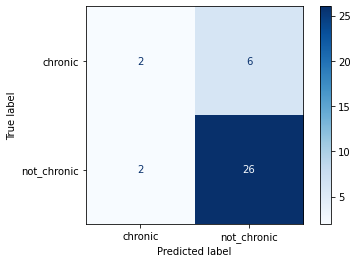

In [7]:
#logistic regression using just first 10 PCA components
pca = PCA(n_components=10)

pca.fit(X_train_scaled)
#PCA transformed data
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
X_val = pca.transform(X_val_scaled)

#logistic regression
logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter=5000, penalty='l2')
logisticRegr.fit(X_train, y_train)
logisticRegr.score(X_test, y_test)

#confusion matrix 
plot_confusion_matrix(logisticRegr, X_test, y_test, cmap=plt.cm.Blues)

In [8]:
#re-defining 95% variance PCA for SVM
#PCA with 95% variation
pca = PCA(.95)

pca.fit(X_train_scaled)
#PCA transformed data
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
X_val = pca.transform(X_val_scaled)

In [9]:
#defining SVM classifiers with different parameters
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']
#A function which returns the corresponding SVC model
def getClassifier(ktype,gamma_val,c_val):
    if ktype == 0:
        # Polynomial kernal
        return svm.SVC(kernel='poly', degree=8, gamma=gamma_val,C=c_val)
    elif ktype == 1:
        # Radial Basis Function kernal
        return svm.SVC(kernel='rbf', gamma=gamma_val,C=c_val)
    elif ktype == 2:
        # Sigmoid kernal
        return svm.SVC(kernel='sigmoid', gamma=gamma_val,C=c_val)
    elif ktype == 3:
        # Linear kernal
        return svm.SVC(kernel='linear', gamma=gamma_val,C=c_val)

In [10]:
# Try multiple different Kernels, c, and gamma
svm_scores = dict()

for i in range(4):
    for c_val in [0.1,1, 10, 100]:
        for gamma_val in [1,0.1,0.01,0.001]:
            run_name = kernels[i]+" "+str(c_val) + " " + str(gamma_val)
            clf = getClassifier(i,gamma_val,c_val) 
            clf.fit(X_train, y_train)# Make prediction
            y_pred = clf.predict(X_val)# Evaluate our model

            class_dict = classification_report(y_val,y_pred, output_dict=True,zero_division=1)
            svm_scores[run_name] = class_dict
    

chron_recall_list = list()
chron_prec_list = list()

for key in svm_scores:
    chron_recall_list.append((svm_scores[key]['chronic']['recall'],key))
    chron_prec_list.append((svm_scores[key]['chronic']['precision'],key))

chron_recall_list.sort(reverse=True)
chron_prec_list.sort(reverse=True)

In [11]:
chron_recall_list[:20]

[(0.6923076923076923, 'Sigmoid 10 0.001'),
 (0.6923076923076923, 'Sigmoid 1 0.001'),
 (0.5384615384615384, 'Sigmoid 100 0.001'),
 (0.5384615384615384, 'Polynomial 100 0.001'),
 (0.46153846153846156, 'RBF 1 0.001'),
 (0.46153846153846156, 'Polynomial 100 1'),
 (0.46153846153846156, 'Polynomial 100 0.1'),
 (0.46153846153846156, 'Polynomial 100 0.01'),
 (0.46153846153846156, 'Polynomial 10 1'),
 (0.46153846153846156, 'Polynomial 10 0.1'),
 (0.46153846153846156, 'Polynomial 10 0.01'),
 (0.46153846153846156, 'Polynomial 10 0.001'),
 (0.46153846153846156, 'Polynomial 1 1'),
 (0.46153846153846156, 'Polynomial 1 0.1'),
 (0.46153846153846156, 'Polynomial 1 0.01'),
 (0.46153846153846156, 'Polynomial 0.1 1'),
 (0.46153846153846156, 'Polynomial 0.1 0.1'),
 (0.46153846153846156, 'Polynomial 0.1 0.01'),
 (0.38461538461538464, 'Sigmoid 100 0.01'),
 (0.38461538461538464, 'Sigmoid 10 0.01')]

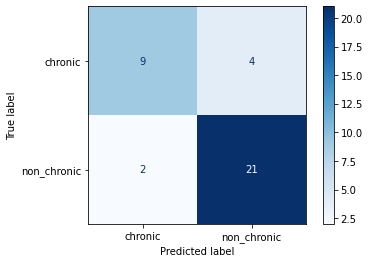

In [12]:
#optimal SVM classifier
#fit the training data and run on validation data
clf = getClassifier(2 ,c_val = 1,gamma_val = 0.001)

clf.fit(X_train, y_train)

plot_confusion_matrix(clf, X_val, y_val,
                                 display_labels=['chronic','non_chronic'],
                                 cmap=plt.cm.Blues)


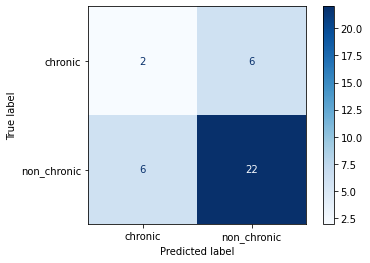

In [13]:
#using SVM tuned parameters on test data
clf = svm.SVC(kernel='sigmoid', gamma=0.001, C=1)
clf.fit(X_train, y_train)

plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['chronic','non_chronic'],
                                 cmap=plt.cm.Blues)

### PCA GRAPHS

In [14]:
#read data
batch_data = pd.read_csv("downloads/data/batch_meta_combine.csv")

# Rename herd to keep it in regex
batch_data = batch_data.rename(columns={'herd': 'herdx'})

#Split into X and Y
X = batch_data.filter(regex=("x.*"))
y = batch_data['group_class']

#onehot encode herd
one_hot = pd.get_dummies(X['herdx'])

# Dropherd as it is now encoded
X = X.drop('herdx',axis = 1)
# Join the encoded df
X = X.join(one_hot)

# revalue chronic = 1; not_chronic = 0
y = y.replace("chronic", "1")
y = y.replace("not_chronic", "0")

# Split into Training and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Standardize X data
scaler = preprocessing.StandardScaler().fit(X_train)

scaler.mean_
scaler.scale_

#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)


array([3.10536111e+05, 7.55343879e+04, 3.91656811e+04, ...,
       3.82023203e-01, 1.00000000e+00, 2.14582818e-01])

In [15]:
# Standardizing the features
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

#Final data frame with PC1, PC2, group class, and herds
finalDf = pd.concat([principalDf, batch_data[['group_class']], batch_data[['herdx']]], axis = 1)
finalDf

,principal component 1,principal component 2,group_class,herdx
0,-13.621626,10.493824,not_chronic,Badlands
1,-17.959801,7.340189,not_chronic,Badlands
2,-11.583655,9.092847,not_chronic,Badlands
3,-14.457887,10.184109,not_chronic,Badlands
4,-14.373820,9.984883,not_chronic,Badlands
...,...,...,...,...
173,8.514334,0.972043,not_chronic,Lostine
174,-7.658841,-13.290989,not_chronic,Lostine
175,2.801700,-3.997221,not_chronic,Lostine
176,12.191561,10.477868,not_chronic,Lostine


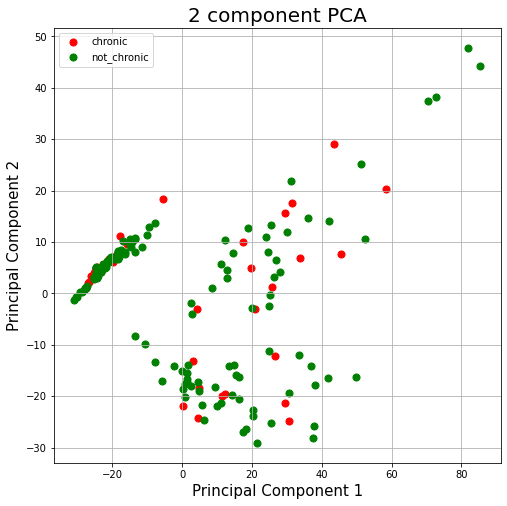

In [16]:
#chronic vs non-chronic PCA figure
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['chronic', 'not_chronic']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['group_class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

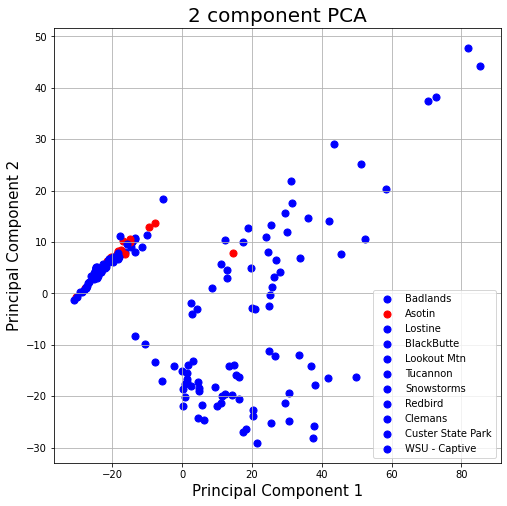

In [18]:
#PCA graph color-coded by herds
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Badlands', 'Asotin', 'Lostine', 'BlackButte', 'Lookout Mtn',
       'Tucannon', 'Snowstorms', 'Redbird', 'Clemans',
       'Custer State Park', 'WSU - Captive']

#change color to blue(b), red(r) based on the desired herd group
colors = ['b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['herdx'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()